In [1]:
from collections.abc import Iterable
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import numba
import correctionlib
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

In [2]:
nevts = 10000
filename = "/pnfs/psi.ch/cms/trivcat/store/user/mmarcheg/RunIIFall17NanoAODv7/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/587E2464-42CA-3A45-BD49-D23E49F658E6.root"
#events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=nevts).events()

In [3]:
def metric_pt(obj, obj2):
    return abs(obj.pt - obj2.pt)

@numba.jit
def get_matching_pairs_indices(idx_quark, idx_jets, builder, builder2):
    for ev_q, ev_j in zip(idx_quark, idx_jets):
        builder.begin_list()
        builder2.begin_list()
        q_done = []
        j_done = []
        for i, (q,j) in enumerate(zip(ev_q, ev_j)):
            if q not in q_done:
                if j not in j_done:
                    builder.append(i)
                    q_done.append(q)
                    j_done.append(j)
                else:
                    #builder.append(None)
                    builder2.append(i)
        builder.end_list()
        builder2.end_list()
    return builder, builder2

@numba.jit
def get_matching_objects_indices_padnone(idx_matched_obj, idx_matched_obj2, num_jets, deltaR, builder, builder2, builder3):
    for ev1_match, ev2_match, nj, dr in zip(idx_matched_obj, idx_matched_obj2, num_jets, deltaR):
        #print(ev1_match, ev2_match)
        builder.begin_list()
        builder2.begin_list()
        builder3.begin_list()
        row1_length = len(ev1_match)
        row2_length = nj
        missed = 0
        for i in range(row2_length):
            if i in ev2_match:
                #print(i, row1_length)
                builder2.append(i)
                if i-missed < row1_length:
                    builder.append(ev1_match[i-missed])
                    builder3.append(dr[i-missed])
            else:
                builder.append(None)
                builder2.append(None)
                builder3.append(None)
                missed += 1
        builder.end_list()
        builder2.end_list()
        builder3.end_list()
    return builder, builder2, builder3

In [4]:
def object_matching_padnone(obj, obj2, dr_min, dpt_max=None):
    # Compute deltaR(quark, jet) and save the nearest jet (deltaR matching)
    deltaR = ak.flatten(obj.metric_table(obj2), axis=2)
    # Keeping only the pairs with a deltaR min
    maskDR = deltaR < dr_min
    if dpt_max is not None:
        deltaPt_table = obj.metric_table(obj2, metric=metric_pt)
        # Check if the pt cut is an iterable or a scalar
        if isinstance(dpt_max, Iterable):
            # Broadcast and flatten pt_min array in order to match the shape of the metric_table()
            dpt_max_broadcast = ak.broadcast_arrays(dpt_max[:,np.newaxis], deltaPt_table)[0]
            dpt_max  = ak.flatten(dpt_max_broadcast, axis=2)
        deltaPt = ak.flatten(deltaPt_table, axis=2)
        maskPt = deltaPt < dpt_max
        maskDR = maskDR & maskPt
    idx_pairs_sorted = ak.argsort(deltaR, axis=1)
    pairs = ak.argcartesian([obj, obj2])
    pairs_sorted  = pairs[idx_pairs_sorted]
    deltaR_sorted = deltaR[idx_pairs_sorted]
    maskDR_sorted = maskDR[idx_pairs_sorted]
    idx_obj, idx_obj2 = ak.unzip(pairs_sorted)
    
    _idx_matched_pairs, _idx_missed_pairs = get_matching_pairs_indices(idx_obj, idx_obj2, ak.ArrayBuilder(), ak.ArrayBuilder())
    idx_matched_pairs = _idx_matched_pairs.snapshot()
    idx_missed_pairs  = _idx_missed_pairs.snapshot()
    # The indices related to the invalid jet matches are skipped
    idx_matched_obj  = idx_obj[idx_matched_pairs]
    idx_matched_obj2 = idx_obj2[idx_matched_pairs]
    deltaR_matched = deltaR_sorted[idx_matched_pairs]
    maskDR_matched = maskDR_sorted[idx_matched_pairs]
    # In order to keep track of the invalid jet matches, the indices of the second collection
    # are sorted, and the order of the first collection of indices is reshuffled accordingly
    obj2_order = ak.argsort(idx_matched_obj2)
    idx_obj_obj2sorted  = idx_matched_obj[obj2_order]
    idx_obj2_obj2sorted = idx_matched_obj2[obj2_order]
    deltaR_obj2sorted = deltaR_matched[obj2_order]
    maskDR_obj2sorted = maskDR_matched[obj2_order]
    # Here we apply the deltaR + pT requirements on the objects
    idx_obj_obj2sorted_masked  = idx_obj_obj2sorted[maskDR_obj2sorted]
    idx_obj2_obj2sorted_masked = idx_obj2_obj2sorted[maskDR_obj2sorted]
    deltaR_final = deltaR_obj2sorted[maskDR_obj2sorted]
    #idx_obj_sorted_masked  = idx_obj_sorted
    #idx_obj2_sorted_masked = idx_obj2_sorted

    _idx_obj_sorted_padnone, _idx_obj2_sorted_padnone, _deltaR_final_padnone = get_matching_objects_indices_padnone(idx_obj_obj2sorted_masked, 
                                                                                             idx_obj2_obj2sorted_masked, 
                                                                                             ak.num(obj2), deltaR_final,
                                                                                             ak.ArrayBuilder(), ak.ArrayBuilder(), ak.ArrayBuilder())
    idx_obj_sorted_padnone  = _idx_obj_sorted_padnone.snapshot()
    idx_obj2_sorted_padnone = _idx_obj2_sorted_padnone.snapshot()
    deltaR_final_padnone    = _deltaR_final_padnone.snapshot()
    # Finally the objects are sliced through the padded indices
    # In this way, to a None entry in the indices will correspond a None entry in the object
    matched_obj  = obj[idx_obj_sorted_padnone]
    matched_obj2 = obj2[idx_obj2_sorted_padnone]

    return matched_obj, matched_obj2, deltaR_final_padnone, maskDR_obj2sorted

In [5]:
jsonfile = '/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/JME/2017_UL/jet_jerc.json.gz'
JECfile = correctionlib.CorrectionSet.from_file(jsonfile)
corrected_jets = events.Jet
corrected_jets['rho'] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll, events.Jet.pt)[0]

JERversion = "Summer19UL17_JRV2_MC"
typeJet    = "AK4PFchs"
sf  = JECfile[f'{JERversion}_ScaleFactor_{typeJet}']
res = JECfile[f'{JERversion}_PtResolution_{typeJet}']
genjets = events['GenJet']
j, nj   = ak.flatten(corrected_jets), ak.num(corrected_jets)
gj, ngj = ak.flatten(genjets), ak.num(genjets)
flatScaleFactor  = sf.evaluate(j['eta'].to_numpy(), 'nom')
flatPtResolution = res.evaluate(j['eta'].to_numpy(), j['pt'].to_numpy(), j['rho'].to_numpy())
scaleFactor  = ak.unflatten(flatScaleFactor, nj)
ptResolution = ak.unflatten(flatPtResolution, nj)
# Match jets with gen-level jets, with DeltaR and DeltaPt requirements
dr_min = {'AK4PFchs' : 0.2, 'AK8PFPuppi' : 0.4}[typeJet]  # Match jets within a cone with half the jet radius
dpt_max = 3 * ptResolution * corrected_jets['pt']          # Match jets whose pt does not differ more than 3 sigmas from the gen-level pt

In [6]:
matched_genjets, matched_jets, deltaR_matched, maskDR_matched = object_matching_padnone(genjets, corrected_jets, dr_min, dpt_max)

In [7]:
for i in range(10):
    print(matched_jets.pt[i].tolist())

[178.25, 95.125, 75.1875, 51.5625, 43.625, 35.21875, 35.03125, 28.296875, 22.375, 19.484375]
[215.375, None, 96.875, 55.875, 35.375, 22.3125, 19.171875, 17.578125, None]
[115.8125, 107.5, 98.3125, 64.125, 36.28125, 22.34375, 21.265625, 19.40625, 17.53125, None]
[149.75, 113.8125, 103.4375, 57.0625, 55.53125, 43.03125, 40.1875, 18.78125]
[119.4375, 96.875, 55.03125, 44.34375, 41.71875]
[95.3125, 75.75, None, None, 43.59375, 26.75, 15.859375]
[368.0, 138.75, 130.25, 101.625, 39.84375, 24.125]
[378.75, 205.75, 174.5, 68.5625, 46.34375, 42.0, 38.5625, 31.375, 19.515625, None, 15.4140625]
[79.0625, 66.4375, 59.1875, 51.90625, 49.15625, 44.09375, 42.375, 31.265625, None, None]
[85.0, 68.0, 62.25, 51.5625, 50.34375, 38.875, 38.84375, 31.3125, 22.359375, None, 20.765625, None]


In [8]:
corrFactor = 1 + (scaleFactor - 1) * (matched_jets['pt'] - matched_genjets['pt']) / matched_jets['pt']
corrFactor[15].tolist()

[0.9967811331070755,
 0.9878965419921875,
 1.0005662163566256,
 1.0131196739651864,
 1.0241678384024702,
 1.0535656845113477,
 0.9921053302887561,
 0.9877961891351744,
 None,
 None,
 0.9804368606166926]

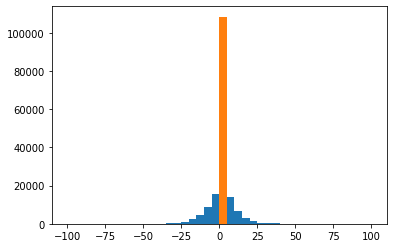

In [9]:
n, bins, patches = plt.hist(ak.flatten(matched_jets.pt - matched_genjets.pt), bins=np.linspace(-100,100,41));
plt.hist(ak.flatten(ptResolution), bins=bins);

## Plot of $\Delta p_T$ cut as a function of $p_T$

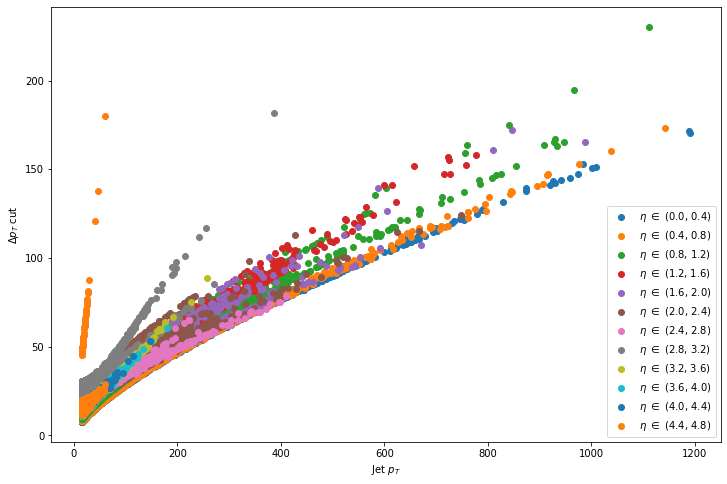

In [10]:
eta_bins = np.linspace(0, 4.8, 13)
binwidth = eta_bins[1] - eta_bins[0]
regions = [((abs(corrected_jets.eta) > eta_min) & (abs(corrected_jets.eta) < eta_max)) for eta_min, eta_max in zip(eta_bins[:-1], eta_bins[1:])]
plt.figure(figsize=[12,8])
for region, eta_bin in zip(regions, eta_bins):
    plt.scatter(ak.flatten(corrected_jets.pt[region]), ak.flatten(dpt_max[region]), label=f'$\eta$ $\in$ ({round(eta_bin,1)}, {round(eta_bin+binwidth,1)})');
plt.xlabel("Jet $p_T$")
plt.ylabel("$\Delta p_T$ cut")
plt.legend(loc='best');

In [11]:
genjets[0].pt.tolist()

[186.9935302734375,
 96.59854125976562,
 70.84357452392578,
 46.89046859741211,
 45.410621643066406,
 37.62003707885742,
 21.63822364807129,
 20.361167907714844,
 16.838815689086914,
 13.847952842712402]

In [12]:
dpt_max[0].tolist()

[47.46838611685613,
 28.857709804554297,
 27.202739919588147,
 19.96952391879229,
 22.58590234259607,
 15.561919495444622,
 15.513431723361212,
 14.141391188553516,
 12.067688479301513,
 15.710699907735421]

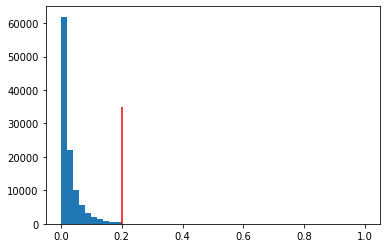

In [13]:
plt.hist(ak.flatten(deltaR_matched), bins=np.linspace(0,1,51));
plt.vlines(0.2, 0, 35000, color='red');

In [14]:
deltaR_matched[15].tolist()

[0.010021667927503586,
 0.02249971404671669,
 0.02221008948981762,
 0.028414864093065262,
 0.009599415585398674,
 0.0732421875,
 0.06163635477423668,
 0.02250865288078785,
 None,
 None,
 0.033886827528476715]

In [15]:
ptResolution_flat, njet = ak.flatten(ptResolution), ak.num(ptResolution)
njet

<Array [10, 9, 10, 8, 5, 7, ... 6, 8, 9, 8, 9] type='10000 * int64'>

In [16]:
rand_gaus = np.random.normal(np.zeros_like(ptResolution_flat), ptResolution_flat)
rand_gaus

array([-0.06951774, -0.07037635,  0.15155881, ...,  0.49668992,
        0.11933626,  0.29674959])

In [17]:
jersmear = ak.unflatten(rand_gaus, njet)
jersmear

<Array [[-0.0695, -0.0704, ... 0.119, 0.297]] type='10000 * var * float64'>

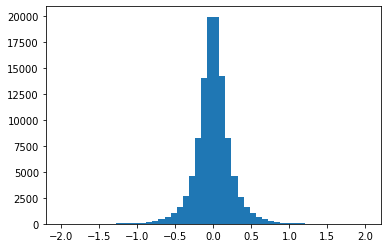

In [18]:
plt.hist(rand_gaus, bins=np.linspace(-2, 2, 51));

In [19]:
w = ak.where(flatScaleFactor**2 - 1 > 0, flatScaleFactor**2 - 1, ak.zeros_like(flatScaleFactor))
w

<Array [0.192, 0.228, 0.192, ... 0.289, 0.248] type='108487 * float64'>

In [20]:
np.sqrt(w)

<Array [0.438, 0.478, 0.438, ... 0.537, 0.498] type='108487 * float64'>